In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os
import zipfile
import random
import cv2

In [10]:
random.seed(42)
zip_path = '/content/drive/MyDrive/Colab Notebooks/weid/w7/Xray.zip'
temp_dir = '/content/drive/MyDrive/Colab Notebooks/weid/w7/temp'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

In [50]:
labels = ['opacity', 'normal']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
train = get_training_data('/content/drive/MyDrive/Colab Notebooks/weid/w7/temp/data')

test = get_training_data('/content/drive/MyDrive/Colab Notebooks/weid/w7/temp/test_data')

<ipython-input-50-d118f72a1924>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [29]:
train[0][0].shape

(150, 150)

In [23]:
test.shape

(74, 2)

Text(0.5, 1.0, 'normal')

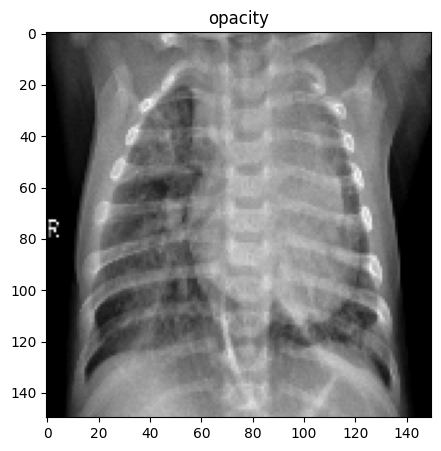

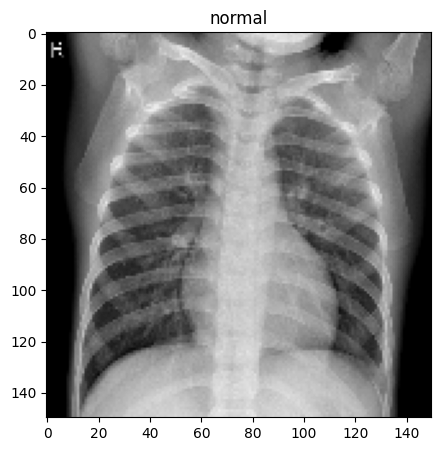

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(train[0][0], cmap = 'gray')
plt.title(labels[train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(train[-1][0], cmap = 'gray')
plt.title(labels[train[-1][1]])

In [51]:
x_train = []
y_train = []
x_test =[]
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in train:
    x_test.append(feature)
    y_test.append(label)    

In [52]:
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

In [53]:
x_train = x_train.reshape(-1,img_size,img_size,1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,img_size,img_size,1)
y_test = np.array(y_test)

In [49]:
x_test.shape

(550, 150, 150, 1)

In [38]:
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False, 
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False, 
                             zca_whitening=False, 
                             zca_epsilon=1e-6, 
                             rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             brightness_range=None,
                             shear_range=0.0,
                             zoom_range=0.2,
                             channel_shift_range=0.0,
                             fill_mode="nearest",
                             cval=0.0,
                             horizontal_flip=True,
                             )
datagen.fit(x_train)

### Model

In [39]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides = 1, activation='relu',padding = 'same',input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(64,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(64,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(128,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Conv2D(256,(3,3),strides = 1, activation='relu',padding = 'same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides = 2,padding='same'))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',factor=0.3,patience=2,min_lr=0.000001,verbose = 1)

In [57]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=32),epochs = 12, callbacks=[learning_rate_reduction])

Epoch 1/12
18/18 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9400

18/18 [==============================] - 2s 97ms/step - loss: 0.1545 - accuracy: 0.9400 - lr: 2.7000e-05
Epoch 2/12
18/18 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9436

18/18 [==============================] - 1s 69ms/step - loss: 0.1479 - accuracy: 0.9436 - lr: 2.7000e-05
Epoch 3/12
18/18 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9382

18/18 [==============================] - 1s 68ms/step - loss: 0.1409 - accuracy: 0.9382 - lr: 2.7000e-05
Epoch 4/12
18/18 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9473

18/18 [==============================] - 1s 67ms/step - loss: 0.1242 - accuracy: 0.9473 - lr: 2.7000e-05
Epoch 5/12
18/18 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9418

18/18 [==============================] - 1s 67ms/step - loss: 0.1464 - accuracy: 0.9418 - lr: 2.7000e-05
Epoch 6/12
18/18 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9509

18/18 [==============================] - 1s 70ms/step - loss: 0.1425 - accuracy: 0.9509 - lr: 2.7000e-05
Epoch 7/12
18/18 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9382

18/18 [==============================] - 1s 69ms/step - loss: 0.1469 - accuracy: 0.9382 - lr: 2.7000e-05
Epoch 8/12
18/18 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9473

18/18 [==============================] - 1s 68ms/step - loss: 0.1297 - accuracy: 0.9473 - lr: 2.7000e-05
Epoch 9/12
18/18 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9345

18/18 [==============================] - 2s 85ms/step - loss: 0.1423 - accuracy: 0.9345 - lr: 2.7000e-05
Epoch 10/12
18/18 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9473

18/18 [==============================] - 2s 99ms/step - loss: 0.1373 - accuracy: 0.9473 - lr: 2.7000e-05
Epoch 11/12
18/18 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9418

18/18 [==============================] - 2s 84ms/step - loss: 0.1362 - accuracy: 0.9418 - lr: 2.7000e-05
Epoch 12/12
18/18 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.9436

18/18 [==============================] - 1s 67ms/step - loss: 0.1450 - accuracy: 0.9436 - lr: 2.7000e-05


In [58]:
predictions = model.predict(x_test)

18/18 [==============================] - 0s 10ms/step


In [64]:
np.round(predictions).T - y_train

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.